# Transformation tendencies due to surface salt/heat flux
### LLC4320

In [36]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [37]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.936fd6552f2f4fa7a0075e84de1dcbed/status,


In [56]:
client.close()
cluster.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = open_catalog(url)
sst  = cat["LLC4320_SST"].to_dask()
sss  = cat["LLC4320_SSS"].to_dask()
grid = cat["LLC4320_grid"].to_dask()

In [3]:
merge = xr.merge([sst, sss.SSS, grid])

In [4]:
merge

<xarray.Dataset>
Dimensions:  (time: 9030, face: 13, j: 4320, i: 4320, k_p1: 2, j_g: 4320,
              i_g: 4320)
Coordinates: (12/37)
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    ...       ...
  * k_p1     (k_p1) int64 0 1
    k_u      int64 ...
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSS      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [24]:
ds = faces_dataset_to_latlon(merge, metric_vector_pairs=[])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, j: 12960, time: 9030, i_g: 17280, j_g: 12960,
              k_p1: 2)
Coordinates: (12/37)
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    ...       ...
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Data variables:
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [5]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


#function to open each ds
def open_ds(face_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/' + 
                                              face_file + '.zarr'))
    return ds

In [6]:
face_names = list(['face0','face1','face2','face3',
                   'face4','face5','face6','face7',
                   'face8','face9','face10','face11','face12',])

face_ds = list()

In [7]:
#load in tendencies by face
for name in face_names:
    face_ds.append(open_ds(name))
    for ds in face_ds:
        globals()[name] = ds

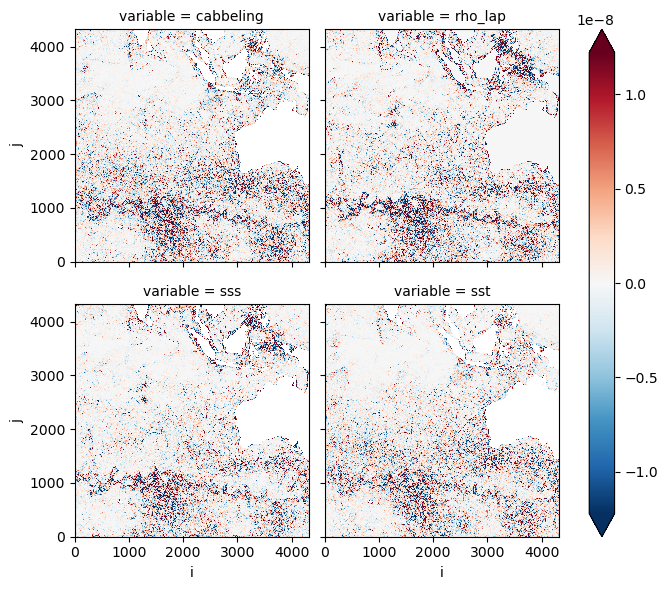

In [10]:
face4.isel(time=83).to_array().plot(col='variable', col_wrap=2, robust=True);

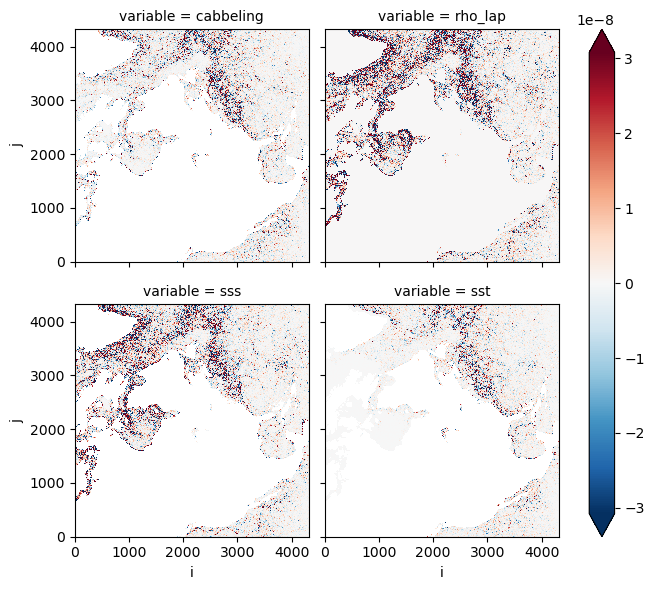

In [11]:
face10.isel(time=83).to_array().plot(col='variable', col_wrap=2, robust=True);

In [12]:
#check residual for random face during random timestep
residual = face10.rho_lap + face10.cabbeling - face10.sst - face10.sss

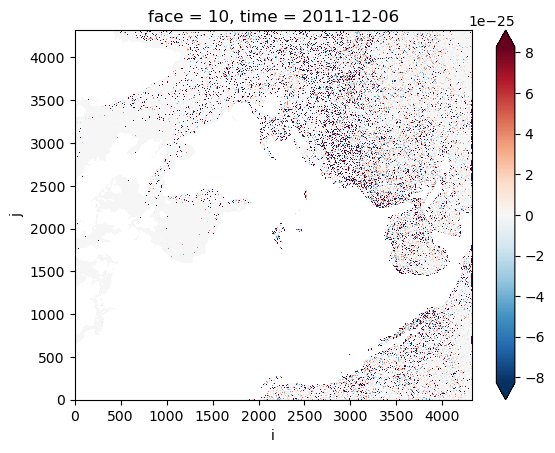

In [13]:
residual.isel(time=84).plot(robust=True);

In [8]:
concat_ds = xr.concat([face_ds[0], face_ds[1]], dim='face')

for face in face_ds[2:]:
    concat_ds =  xr.concat([concat_ds, face], dim='face')

In [9]:
concat_ds

<xarray.Dataset>
Dimensions:    (face: 13, time: 377, j: 4320, i: 4320)
Coordinates:
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j          (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time       (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-23
Data variables:
    cabbeling  (face, time, j, i) float64 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    rho_lap    (face, time, j, i) float64 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    sss        (face, time, j, i) float64 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    sst        (face, time, j, i) float64 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [12]:
concat_ds_reorder = concat_ds.transpose('time', "face", "j", "i")

In [14]:
concat_ds_reorder

<xarray.Dataset>
Dimensions:    (face: 13, time: 377, j: 4320, i: 4320)
Coordinates:
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j          (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time       (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-23
Data variables:
    cabbeling  (time, face, j, i) float64 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    rho_lap    (time, face, j, i) float64 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    sss        (time, face, j, i) float64 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    sst        (time, face, j, i) float64 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [15]:
new_ds = faces_dataset_to_latlon(concat_ds_reorder, metric_vector_pairs=[])
new_ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 17280, j: 12960, time: 377)
Coordinates:
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j          (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time       (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-23
Data variables:
    cabbeling  (time, j, i) float64 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rho_lap    (time, j, i) float64 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    sss        (time, j, i) float64 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    sst        (time, j, i) float64 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [16]:
ds_rechunked = new_ds.chunk({'time':1, 'j':12960, 'i':17280})

In [17]:
ds_rechunked

<xarray.Dataset>
Dimensions:    (face: 13, i: 17280, j: 12960, time: 377)
Coordinates:
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j          (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time       (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-23
Data variables:
    cabbeling  (time, j, i) float64 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>
    rho_lap    (time, j, i) float64 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>
    sss        (time, j, i) float64 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>
    sst        (time, j, i) float64 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>

## Create basin masks

In [18]:
!pip install git+https://github.com/mathause/regionmask.git

  Cloning https://github.com/mathause/regionmask.git to /tmp/pip-req-build-gdzucrh3
  Running command git clone --filter=blob:none --quiet https://github.com/mathause/regionmask.git /tmp/pip-req-build-gdzucrh3
  Resolved https://github.com/mathause/regionmask.git to commit 29339a123960bc2006d0dc28ada56c885489c6ff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for regionmask: filename=regionmask-0.9.0.post1.dev63+g29339a1-py3-none-any.whl size=69868 sha256=a3f62484d14a92f8755e3641305ce953050433babd9f6f1d01c7431003c52c27
  Stored in directory: /tmp/pip-ephem-wheel-cache-i_j49bfk/wheels/1a/62/0f/f392f37f9bd2d2d61b9a6b63de17bb421b3f7c2972b03c9934
Successfully built regionmask


In [19]:
!pip install git+https://github.com/jbusecke/xmip.git

  Cloning https://github.com/jbusecke/xmip.git to /tmp/pip-req-build-z5g07pbm
  Running command git clone --filter=blob:none --quiet https://github.com/jbusecke/xmip.git /tmp/pip-req-build-z5g07pbm
  Resolved https://github.com/jbusecke/xmip.git to commit 29d9e5fc4f3396ef2473f74bacda5fb279c444f4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached xgcm-0.6.1-py3-none-any.whl (60 kB)
  Created wheel for xmip: filename=xmip-0.7.2.dev13+g29d9e5f-py3-none-any.whl size=58767 sha256=8ad55a94cab1e37871fbbe936c59e4d1da029174e42865dded4e845922539b44
  Stored in directory: /tmp/pip-ephem-wheel-cache-cvi9vpm_/wheels/14/81/1d/2382ef5c4df3bc79c5b5a3c37400af047e5a775a4b2cf79b42
Successfully built xmip
  Attempting uninstall: xgcm
    Found existing installation: xgcm 0.8.1
    Uninstalling xgcm-0.8.1:
      Successfully uninstalled xgcm-0.8.1
  Attempting uninstall: xmip
    Found existing installation: 

In [20]:
import regionmask  
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask

<GeoAxes: >

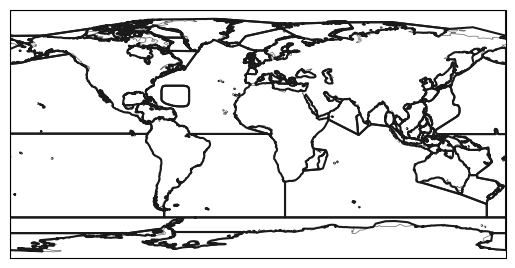

In [21]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)

In [25]:
coorded = ds_rechunked.assign_coords({'XC':ds.XC, 'YC':ds.YC})

In [28]:
da = coorded.sss.isel(time=0).squeeze()

In [32]:
da_drop = da.drop_vars([
'time',
'CS',
'Depth',
'PHrefC',
'SN',
'Z',
'Zl',
'Zu',
'drF',
'hFacC',
'k',
'k_l',
'k_u',
'rA'])

In [33]:
da_renamed = da_drop.rename({'YC':'lat', 'XC':'lon'})#.load()

In [34]:
da_renamed

<xarray.DataArray 'sss' (j: 12960, i: 17280)>
dask.array<getitem, shape=(12960, 17280), dtype=float64, chunksize=(12960, 17280), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    lat      (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>

In [50]:
mask = merged_mask(basins, da_renamed)

/srv/conda/envs/notebook/lib/python3.10/site-packages/regionmask/core/mask.py:175: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/pygeos/io.py:523: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [51]:
mask

<xarray.DataArray 'mask' (j: 12960, i: 17280)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    lat      (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>

In [52]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [55]:
mask_ds = mask.to_dataset(name='basin_mask')

In [56]:
mask_ds

<xarray.Dataset>
Dimensions:     (i: 17280, j: 12960)
Coordinates:
  * i           (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j           (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    lat         (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    lon         (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Data variables:
    basin_mask  (j, i) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [57]:
gcsmap_mask = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/basin_mask.zarr')
mask_ds.to_zarr(gcsmap_mask, mode='w')

In [68]:
mask_ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/basin_mask.zarr'))

In [73]:
mask = mask_ds.basin_mask
mask.load()

<xarray.DataArray 'basin_mask' (j: 12960, i: 17280)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    lat      (j, i) float32 -88.18 -88.18 -88.18 -88.19 ... 67.5 67.5 67.5 67.5
    lon      (j, i) float32 -114.9 -114.9 -114.9 -114.9 ... -38.01 -38.0 -38.0

In [74]:
mask.nbytes/1e9

1.7915904

In [1]:
mask.plot(cmap='tab20');

NameError: name 'mask' is not defined

In [ ]:
mask.basin_mask.where(mask.basin_mask==0).plot();

In [22]:
#assign each region index value to basin name

north_atlantic_ocean = 0
south_atlantic_ocean = 1
north_pacific_ocean = 2
south_pacific_ocean = 3
south_china_seas = 4
indian_ocean = 5
arctic_ocean = 6
southern_ocean = 7
black_sea = 8
med_sea = 9
red_sea = 10
baltic_sea = 12 #no 11

## Split salt/heat tendencies by basin

In [34]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [35]:
#combining atl, lab and norwegian sea masks together
nor_bool = ds.REGION_MASK.where(ds.REGION_MASK==9).notnull()
lab_bool = ds.REGION_MASK.where(ds.REGION_MASK==8).notnull()
atl_bool = ds.REGION_MASK.where(ds.REGION_MASK==6).notnull()

In [36]:
atl_mask = (nor_bool+lab_bool+atl_bool)

In [37]:
def basin_selection(ds, basin):
    tendency_in_basin = ds.where(ds.REGION_MASK==basin)
    return tendency_in_basin

In [38]:
all_tendencies = list(surf_tend)

In [39]:
#Atlantic Ocean - going to add 'NATL' prefix after adding natl_ocean+nor_sea+lab_sea respective vars
natl_ocean = xr.merge([surf_tend[var].where(atl_mask).isel(nlat=slice(1200, None)
                                                          ).rename('NATL_' + var) for var in all_tendencies])
satl_ocean = xr.merge([basin_selection(surf_tend[var], 
                                      atlantic_ocean).isel(nlat=slice(None, 1200)
                                                          ).rename('SATL_' + var) for var in all_tendencies])

#Pacific Ocean
npac_ocean = xr.merge([basin_selection(surf_tend[var], 
                                       pacific_ocean).isel(nlat=slice(1200, None)
                                                          ).rename('NPAC_' + var) for var in all_tendencies])
spac_ocean = xr.merge([basin_selection(surf_tend[var], 
                                       pacific_ocean).isel(nlat=slice(None, 1200)
                                                          ).rename('SPAC_' + var) for var in all_tendencies])

#Indian Ocean
ind_ocean = xr.merge([basin_selection(surf_tend[var], indian_ocean).rename('IND_' + var) for var in all_tendencies])

#Arctic Ocean
arc_ocean = xr.merge([basin_selection(surf_tend[var], arctic_ocean).rename('ARC_' + var) for var in all_tendencies])

#Southern Ocean
south_ocean = xr.merge([basin_selection(surf_tend[var], 
                                        southern_ocean).rename('South_' + var) for var in all_tendencies])